# Code for Examining Individual Fit Parameters from the Cosine Moment Extractions

In [2]:
%reset -f
import ROOT
import traceback
from MyCommonAnalysisFunction_richcap import *

# ROOT.TH1.AddDirectory(0)
# ROOT.gStyle.SetTitleOffset(1.3,'y')

# ROOT.gStyle.SetGridColor(17)
# ROOT.gStyle.SetPadGridX(1)
# ROOT.gStyle.SetPadGridY(1)

print(f"{color.BOLD}\nStarting RG-A SIDIS Analysis\n{color.END}")

Welcome to JupyROOT 6.22/06

Starting RG-A SIDIS Analysis



.

.

.

## Specify the Parameter text file to use:

In [3]:
# Define the relative path to the file
file_path = 'SIDIS_python_Images_From_5D_Unfold_Test_V6_5_21_2024/Parameters_5D_Unfold_Test_V6_5_21_2024_Q2_y_Bins_Combined.txt'  # Adjust the path based on your specific directory structure

# Open the file and read its contents into a string
with open(file_path, 'r') as file:
    file_content = file.read()

print(f"{color.BOLD}File: {color.BLUE}{file_path}{color.END_B} has been found...{color.END}")

# # Now `file_content` holds the content of the file as a string
# print(file_content)  # Display the content to verify it's correct


File: SIDIS_python_Images_From_5D_Unfold_Test_V6_5_21_2024/Parameters_5D_Unfold_Test_V6_5_21_2024_Q2_y_Bins_Combined.txt has been found...


In [ ]:
# print(file_content)  # Display the content to verify it's correct

This information is from Pass 1
Note to Reader: Print the text in this file as a string in Python for the best formatting...
This information is from Pass 1

For SMEARED Q2-y Bin 1 - z-PT Bin 1: 
     (*) 1D Histograms:
     - Bin-by-Bin Correction Fits:
             Par A    = 22185.664412399696 ± 165.444441690237
             Par B    = -0.05956159076466437 ± 0.012344649248851279
             Par C    = 0.014129270844056414 ± 0.010400177275995837
             chi2/NDF = 18.218943952308422
     - Bayesian Unfolding Fits:
             Par A    = 22178.033563600424 ± 239.53273163067024
             Par B    = -0.061180934236977694 ± 0.017302826376209144
             Par C    = 0.019778475347036077 ± 0.014613526224944164
             chi2/NDF = 10.388255694610153
     (*) 3D Histograms:
     - Bin-by-Bin Correction Fits:
             Par A    = 22164.84312820618 ± 165.16956985810975
             Par B    = -0.061500847324138894 ± 0.012372620427396945
             Par C    = 0.01290934938

.

.

.

## Declare Pass Version

In [4]:
Pass_Version = "Pass 1"
Pass_Version = "Pass 2" if(any(pass_V in str(file_path) for pass_V in ["Pass_2", "P2"])) else Pass_Version
# Pass_Version = "Pass 2"

print(f"\n{color.BOLD}Pass Version in use = {color.UNDERLINE}{Pass_Version}{color.END}\n")


Pass Version in use = Pass 1



.

.

.

### Remove User text
(Attempts to limit the lines of text included for humans reading the content of the loaded file so that the computer has an easier time searching through the file)

In [12]:
file_content = file_content.replace(f"This information is from {color.BOLD}{Pass_Version}{color.END}", "")
file_content = file_content.replace("""
Note to Reader: Print the text in this file as a string in Python for the best formatting...


""", "")

print(f"\n{color.BOLD}'file_content'{color.END} has been updated\n")


'file_content' has been updated



.

.

.

## Defining Search Functions

In [13]:
def find_bin_block(data, bin_info):
    blocks = re.split(r"==+\n", data)
    for block in blocks:
        if(bin_info in block):
            return f"\n======================================================================\n{block.strip()}\n======================================================================\n"
    return "No data found for the specified Q2-y/z-PT Bin."


def extract_histogram_info(block, histogram_type):
    pattern = rf"{histogram_type} Histograms:(.*?)(?=\(\*\)|\dD Histograms)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return match.group(1).strip()
    else:
        return "No data found for the specified histogram type."
    

def extract_fit_info(block, fit_type):
    pattern = rf"- {re.escape(fit_type)} Fits:.*?(\n\s+Par A.*?chi2/NDF = \S+)"
    match = re.search(pattern, block, re.DOTALL)
    if(match):
        return f"\n{match.group(1).strip()}"
    else:
        return "No fit details found for the specified type."

    
def find_parameter(block, parameter):
    for line in block.split("\n"):
        if(parameter in line):
            par_val = (line.split("="))[1]
            par_val = re.sub(r"{}.*".format(re.escape("±")), "", par_val)
            return par_val
    return "ERROR"
            
            
def Full_Search_Parameter(Parameter_File_str, Bin_Info=False, Histogram_Type=False, Fit_Type=False, Parameter=False):
    Output = "Error"
    if(not Bin_Info):
        print("No kinematic bin given")
        return Parameter_File_str
    else:
        Output = find_bin_block(Parameter_File_str, Bin_Info)
        if(not Histogram_Type):
            print("No histogram given")
            return Output
        else:
            Output = extract_histogram_info(Output, Histogram_Type)
            if(not Fit_Type):
                print("No fit given")
                return Output
            else:
                Output = extract_fit_info(Output, Fit_Type)
                if(not Parameter):
                    print("No parameter given")
                    return Output
                else:
                    Output = find_parameter(Output, Parameter)
                    return Output
    return Output
    
print("Done making search functions")

Done making search functions


.

.

.

In [25]:
String_Print_Cpp = """
float Moment_Measurement[18][37][2][2];

    // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num][Smear_Num]
    // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
    // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
    // Smear_Num  = 0 -> NOT Smeared
    // Smear_Num  = 1 -> Smeared"""
for Q2_y_Bin in range(1, 18):
    if(Q2_y_Bin > 1):
        String_Print_Cpp = f"{String_Print_Cpp}\n"
    for z_pT_Bin in range(1, Get_Num_of_z_pT_Bins_w_Migrations(Q2_y_Bin_Num_In=Q2_y_Bin)[1] + 1):
        Num_Spaces  = " "
        for ii in [Q2_y_Bin, z_pT_Bin]:
            if(ii < 10):
                Num_Spaces += " "
        for Smearing in ["SMEARED ", ""]:
            String_Print_Cpp = f"{String_Print_Cpp}\n"
            if(Smearing in ["SMEARED "]):
                Smear_Num = "1"
                String_Print_Cpp = f"{String_Print_Cpp}\n// (Q2-y) + (z-pT) Bin: ({Q2_y_Bin}) + ({z_pT_Bin})"
            else:
                Smear_Num = "0"
            Bin___Type = f"{Smearing}Q2-y Bin {Q2_y_Bin} - z-PT Bin {z_pT_Bin}"
            Histo_Type = "1D"
            Fit___Type = "Bin-by-Bin Correction"
            if(skip_condition_z_pT_bins(Q2_Y_BIN=Q2_y_Bin, Z_PT_BIN=z_pT_Bin, BINNING_METHOD="Y_bin")):
                for Par___Type in ["B", "C"]:
                    # Moment_Value = "-0.1500" if(Par___Type in ["B"]) else "0.005"
                    Moment_Value = "N/A" if(Par___Type in ["B"]) else "N/A"
                    Moment_Num   =  0        if(Par___Type in ["B"]) else 1
                    String_Print_Cpp = f"""{String_Print_Cpp}
Moment_Measurement[{Q2_y_Bin}][{z_pT_Bin}][{Moment_Num}][{Smear_Num}]{Num_Spaces}=  {Moment_Value};"""
            else:
                for Par___Type in ["B", "C"]:
                    Moment_Value = Full_Search_Parameter(Parameter_File_str=file_content, Bin_Info=Bin___Type, Histogram_Type=Histo_Type, Fit_Type=Fit___Type, Parameter=Par___Type)
                    Moment_Value = str(round(float(Moment_Value), 5))
                    Moment_Num = 0 if(Par___Type in ["B"]) else 1
                    String_Print_Cpp = f"""{String_Print_Cpp}
Moment_Measurement[{Q2_y_Bin}][{z_pT_Bin}][{Moment_Num}][{Smear_Num}]{Num_Spaces}=  {Moment_Value};"""
            
String_Print_Cpp = f"{String_Print_Cpp}\n"
String_Print_Cpp = String_Print_Cpp.replace(";\n", "; \t")
String_Print_Cpp = String_Print_Cpp.replace("  -",  " -")
# String_Print_Cpp = String_Print_Cpp.replace("  ",   " ")


print(f"\n{String_Print_Cpp}\n")

# String_Print_python = String_Print_Cpp.replace("""float Moment_Measurement[18][37][2]; 	
#     // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num]
#     // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
#     // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
#
# """, "")
# String_Print_python = String_Print_python.replace("][", ", ")
# String_Print_python = String_Print_python.replace("[", "['")
# String_Print_python = String_Print_python.replace("]", "']")
# String_Print_python = String_Print_python.replace("; \t", "\n")
# print(String_Print_python)



float Moment_Measurement[18][37][2][2]; 	
    // Moment_Measurement[Q2_y_Bin][z_pT_Bin][Moment_Num][Smear_Num]
    // Moment_Num = 0 -> Cos(phi)   (Fit Par B)
    // Moment_Num = 1 -> Cos(2*phi) (Fit Par C)
    // Smear_Num  = 0 -> NOT Smeared
    // Smear_Num  = 1 -> Smeared

// (Q2-y) + (z-pT) Bin: (1) + (1)
Moment_Measurement[1][1][0][1]   = -0.05956; 	Moment_Measurement[1][1][1][1]   =  0.01413; 	
Moment_Measurement[1][1][0][0]   = -0.05956; 	Moment_Measurement[1][1][1][0]   =  0.01413; 	
// (Q2-y) + (z-pT) Bin: (1) + (2)
Moment_Measurement[1][2][0][1]   = -0.05546; 	Moment_Measurement[1][2][1][1]   =  0.05156; 	
Moment_Measurement[1][2][0][0]   = -0.05546; 	Moment_Measurement[1][2][1][0]   =  0.05156; 	
// (Q2-y) + (z-pT) Bin: (1) + (3)
Moment_Measurement[1][3][0][1]   = -0.11378; 	Moment_Measurement[1][3][1][1]   =  0.0435; 	
Moment_Measurement[1][3][0][0]   = -0.11378; 	Moment_Measurement[1][3][1][0]   =  0.0435; 	
// (Q2-y) + (z-pT) Bin: (1) + (4)
Moment_Measurement[1][4][0][

Welcome to JupyROOT 6.22/06


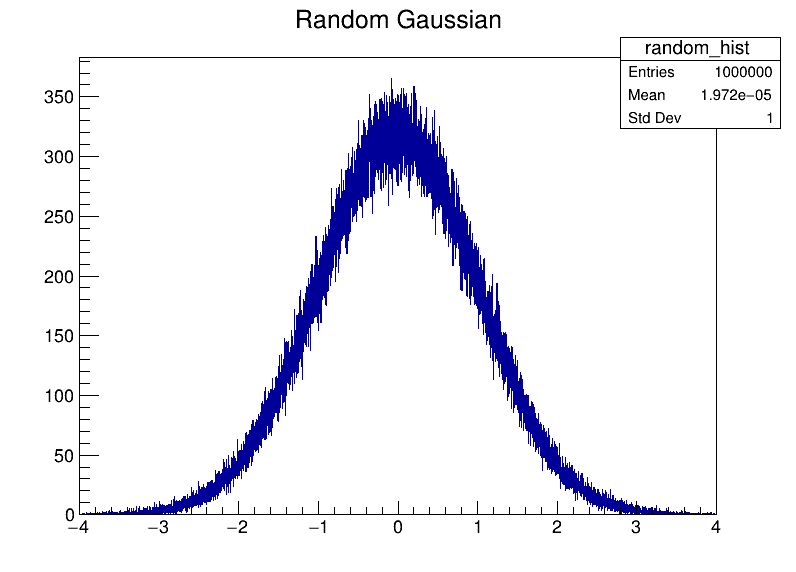

In [1]:
import ROOT
def create_random_histogram():
    # Create a histogram with 100 bins ranging from -4 to 4
    histogram = ROOT.TH1D("random_hist", "Random Gaussian", 10000, -4, 4)

    # Fill the histogram with 1000 random numbers from a Gaussian distribution
    for _ in range(1000000):
        histogram.Fill(ROOT.gRandom.Gaus(0, 1))  # Mean = 0, Standard deviation = 1

    # Set up a canvas to draw the histogram
    canvas = ROOT.TCanvas("canvas", "Canvas for Histogram", 800, 600)
    histogram.Draw()  # Draw the histogram on the canvas

    # Update the canvas to show the histogram
    canvas.Update()

    return canvas, histogram  # Return both the canvas and the histogram for further use

# Run the function to create and show the histogram
canvas, histogram = create_random_histogram()
canvas.Draw()

Current memory usage: 412.59 MB
Current memory usage: 412.59 MB
Current memory usage: 412.61 MB
Current memory usage: 412.63 MB
Current memory usage: 412.63 MB
Done


Warning in <TROOT::Append>: Replacing existing TH1: random_hist (Potential memory leak).


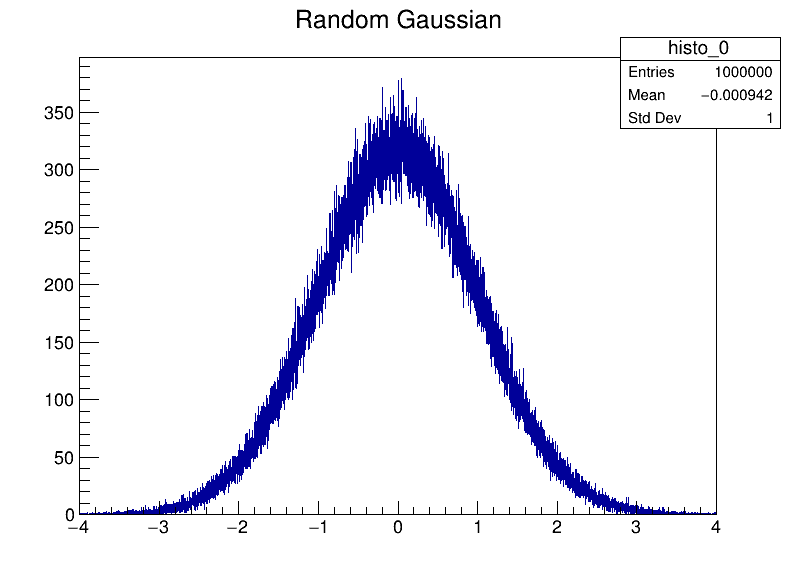

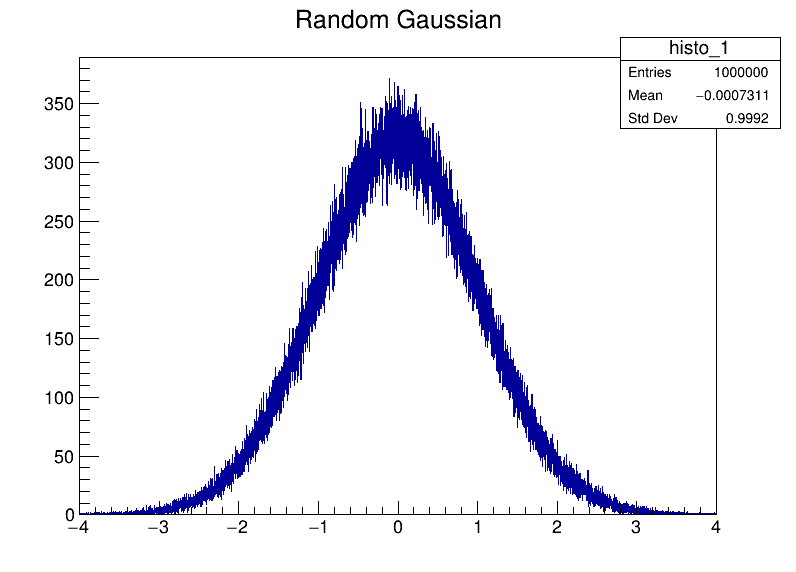

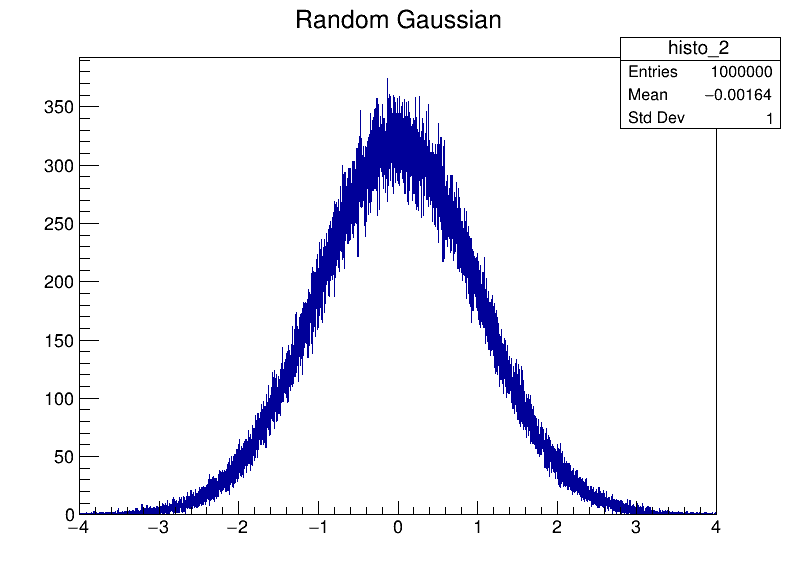

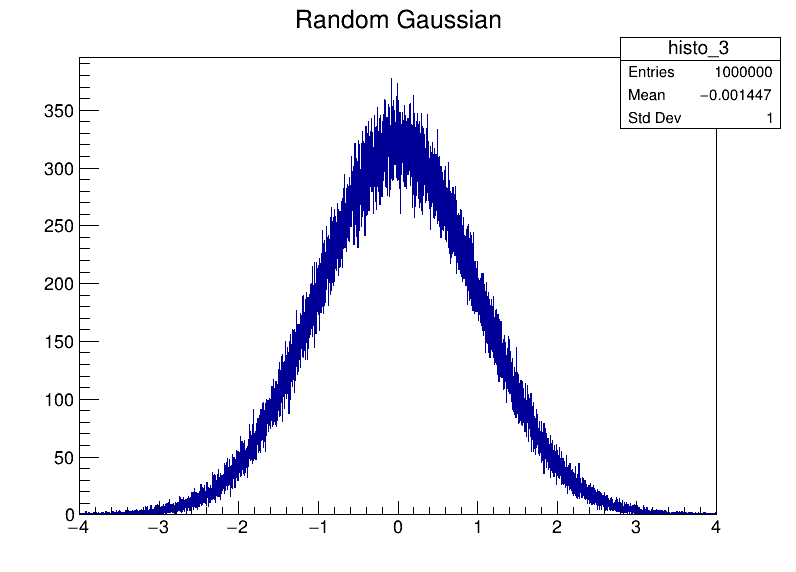

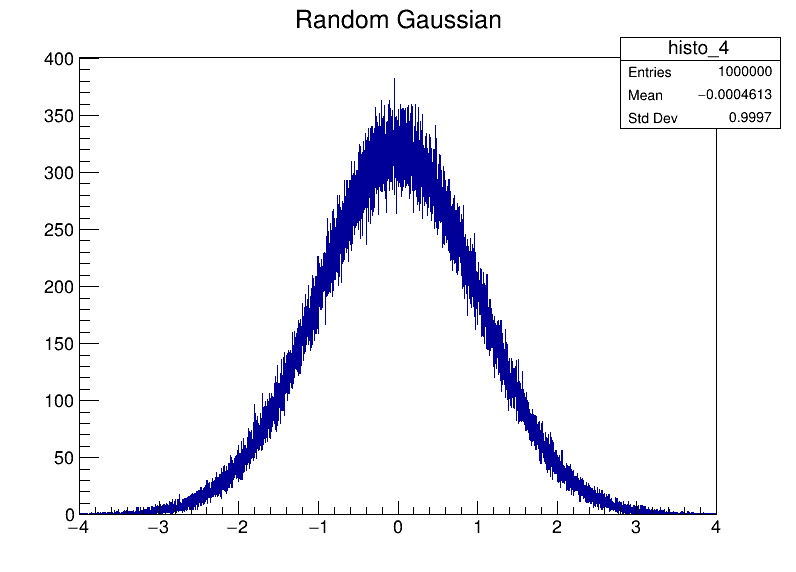

In [2]:
import psutil
import os

# Function to get current process memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())  # Get current process
    memory_info = process.memory_info()  # Get memory usage statistics
    return memory_info.rss  # Return the Resident Set Size (RSS) which is the non-swapped physical memory the process has used


import time
# Example of using the function in a typical script workflow
count = 0
histo, canvas = {}, {}
while(count < 5):  # Example of a loop, replace with your actual use case
    # Do some work here
    canvas[count], histo[count] = create_random_histogram()
    canvas[count].SetName(f"canvas_{count}")
    histo[count].SetName(f"histo_{count}")
    canvas[count].Draw()
    print(f"Current memory usage: {get_memory_usage() / (1024 * 1024):.2f} MB")  # Print memory usage in MB
#     time.sleep(1)  # Sleep for a second, you can adjust or remove according to your needs
    count += 1
print("Done")